# Computation of the area of the intersection of a circle and the Crofton cell

- the Crofton cell is the Voronoi cell which contains (0,0)
- We draw a Poisson point process with 0,0 included
- We compute the Voronoi tesselation and find the coordinates of the vertices of the Crofton cell
- The function *condInsideVoronoi* compute the equations of the lines joining the adjacent points: 
    - For two points $(x_1,y_1)$ and $(x_2, y_2)$, the line joining the two has equation
    $$ -(y_2-y_1)X + (x_2-x_1) Y+(x_1y_2-x_2y_1)=0$$
    - A point $(u,v)$ is on the same side as $(0,0)$ of this line iff
    $$-(y_2-y_1)u + (x_2-x_1) v+(x_1y_2-x_2y_1)$$
    has the sign of $x_1y_2-x_2y_1$
    - La fonction *isInVor* computes all these quantities and verifies that the previous conditions are all satisfied
- For the simulation, we compute the circumscribed circle which contains the Crofton cell then we draw points in this circle. We count 1 if this point has radius less than prescribed in the parameter of the function AND is in the Crofton cell.
- We have
$$\frac{\text{Area}(B(0,radius)\cap \text{Voronoi cell})}{\text{Area}(\text{Circum. circle})}=\text{frequency of points in } B(0,radius)\cap \text{Voronoi cell} $$

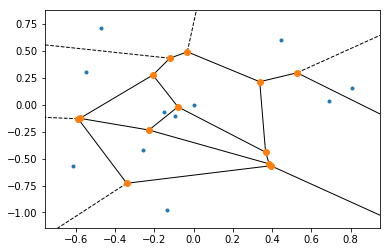

0.21747675144475342

In [183]:
%matplotlib inline
from numpy import *
import numpy as np
from scipy.spatial import Voronoi, voronoi_plot_2d
import matplotlib.pyplot as plt
from numba import jit


points=np.vstack((np.array([0,0]),2*(np.random.rand(10,2)-0.5*np.ones(2))))
vor = Voronoi(points)
fig = voronoi_plot_2d(vor)
plt.show()

@jit()
def condInsideVoronoi(vor):
    pt=vor.vertices
    # We get the Voronoi cell which contains (0,0)
    n=vor.point_region[0]
    # We get its vertices
    vert=vor.regions[n]
    #print(vert)
    # For each pair of consecutive points we compute the equation of the line joining them
    # -(y_2-y_1)X+(x_2-x_1)Y+x_1y_2-x_2y_1
    normals=[]
    constant=[]
    for i in np.arange(len(vert)):
        j=remainder(i+1,len(vert))
        normals += [[-pt[vert[j]][1]+pt[vert[i]][1],pt[vert[j]][0]-pt[vert[i]][0] ]]
        constant +=[[pt[vert[i]][0]*pt[vert[j]][1]-pt[vert[j]][0]*pt[vert[i]][1]]]
    return np.reshape(np.asarray(normals),(len(vert),2)),np.reshape(np.asarray(constant),(len(vert),1))

@jit()
def isInVor(point,vor):
    point=np.transpose(np.asarray(point))
    a,b=condInsideVoronoi(vor)
    z=np.reshape(np.dot(a,point),(shape(a)[0],1))+b
    #print(z,b)
    if (np.sum(z*b<0)==0):
        return True
    else:
        return False

@jit()    
def simulation(radius,vor,N):
    c=0
    vert=vor.vertices
    for x in vor.regions[vor.point_region[0]]:
        r=np.sqrt(vert[x][0]**2+vert[x][1]**2)
        if (r>c):
            c=r
    freq=0
    for i in np.arange(N):
        rr=c*np.sqrt(np.random.rand())
        if (rr < radius):
            angle=2*np.pi*np.random.rand()
            if isInVor([rr*cos(angle),rr*sin(angle)],vor):
                freq+=1
    return freq*1./N*np.pi*radius**2

simulation(0.5,vor,10000)
    

# Simulation of points inside the Crofton cell without rejection

- Divide the Crofton cell in triangles centered at (0,0)
- Compute the area of each triangle, this gives the area of the cell
- Choose a triangle with a probability proportional to its area
- Draw a point uniformly in this triangle, this gives a point unformy distributed in the cell


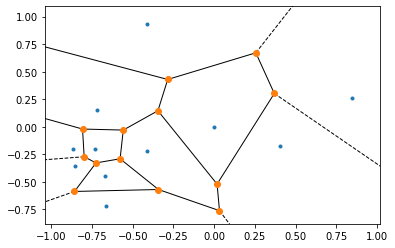

Circumscribed radius  0.7182311601022698


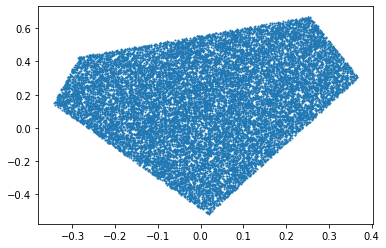

[0.13905 0.48595 0.77425 0.9554  1.     ] [0.0047953  0.00692691 0.00579423 0.00286089 0.        ]


In [40]:
%matplotlib inline
from numpy import *
import numpy as np
from scipy.spatial import Voronoi, voronoi_plot_2d
import matplotlib.pyplot as plt
from numba import jit

points=np.vstack((np.array([0,0]),2*(np.random.rand(10,2)-0.5*np.ones(2))))
vor = Voronoi(points)
fig = voronoi_plot_2d(vor)
plt.show()

def triangleArea(a,b,c):
    return 0.5*np.abs((b[0]-a[0])*(c[1]-a[1])-(c[0]-a[0])*(b[1]-a[1]))

def drawInTriangle(a,b):
    x=np.random.rand()
    y=np.random.rand()
    u=max(x,y)
    v=min(x,y)
    return [a[0]*u+(b[0]-a[0])*v,a[1]*u+(b[1]-a[1])*v]

crofton=vor.vertices[vor.regions[vor.point_region[0]]]
L=len(crofton)
areas=[]
for i in np.arange(L):
    j=remainder(i+1,L)
    areas+= [[triangleArea([0,0],crofton[i],crofton[j])]]
areaCrofton=sum(areas)
areas=np.cumsum(areas)/areaCrofton

plt.clf()
X=[]
Y=[]

c=0
for x in crofton:
    r=np.sqrt(x[0]**2+x[1]**2)
    if (r>c):
        c=r
print("Circumscribed radius ",c)

radiuses=np.cumsum(np.ones(5)/5.)*c
frequencies=np.zeros(5)
N=20000
for i in np.arange(N):
    # Choice of the triangle
    t=0
    alea=np.random.rand()
    while(areas[t]<alea):
        t+=1
    q,s=drawInTriangle(crofton[t],crofton[remainder(t+1,L)])
    radius=np.sqrt(q**2+s**2)
    for i in np.arange(5):
        if (radius<radiuses[i]):
            frequencies[i]+=1
    X+=[q]
    Y+=[s]
plt.scatter(X,Y,s=1)
plt.show()
freq=frequencies/frequencies[4]
var=freq*(1-freq)
print(freq,1.96*np.sqrt(var/N))


In [34]:
frequencies

array([ 391.,  945., 1464., 1880., 2000.])

In [32]:
radiuses

array([0.15654588, 0.31309175, 0.46963763, 0.62618351, 0.78272938])

In [25]:
a=[0]*3+[1]*2

In [26]:
a+a

[0, 0, 0, 1, 1, 0, 0, 0, 1, 1]